In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=500

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "disease",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4817 files belonging to 2 classes.


In [4]:
class_names = dataset.class_names
class_names

['1. Eczema 1677', '2. Melanoma 15.75k']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1]


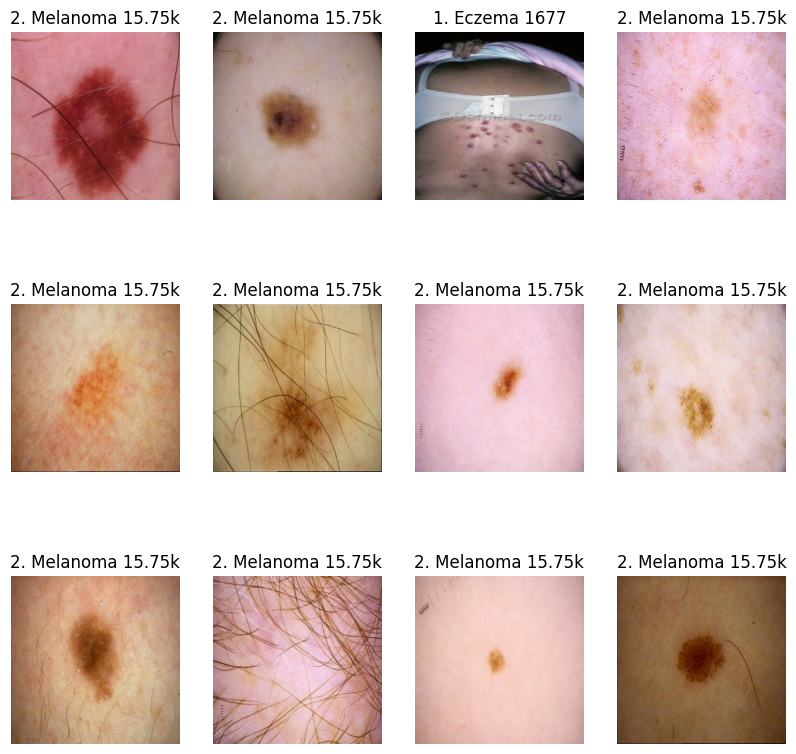

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

151

In [8]:
train_size = 0.8
len(dataset)*train_size

120.80000000000001

In [9]:
train_ds = dataset.take(679)
len(train_ds)

151

In [10]:
test_ds = dataset.skip(679)
len(test_ds)

0

In [11]:
val_size=0.1
len(dataset)*val_size

15.100000000000001

In [12]:
val_ds = test_ds.take(84)
len(val_ds)

0

In [13]:
test_ds = test_ds.skip(84)
len(test_ds)

0

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

120

In [17]:
len(val_ds)

15

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 23

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)


In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/500
120/120 [==============================] - 206s 2s/step - loss: 0.4792 - accuracy: 0.7984 - val_loss: 0.1993 - val_accuracy: 0.9187
Epoch 2/500
120/120 [==============================] - 171s 1s/step - loss: 0.1971 - accuracy: 0.9255 - val_loss: 0.1604 - val_accuracy: 0.9375
Epoch 3/500
120/120 [==============================] - 181s 2s/step - loss: 0.1800 - accuracy: 0.9341 - val_loss: 0.1544 - val_accuracy: 0.9563
Epoch 4/500
120/120 [==============================] - 179s 1s/step - loss: 0.1635 - accuracy: 0.9383 - val_loss: 0.1504 - val_accuracy: 0.9417
Epoch 5/500
120/120 [==============================] - 177s 1s/step - loss: 0.1462 - accuracy: 0.9443 - val_loss: 0.1467 - val_accuracy: 0.9458
Epoch 6/500
120/120 [==============================] - 172s 1s/step - loss: 0.1482 - accuracy: 0.9443 - val_loss: 0.1486 - val_accuracy: 0.9479
Epoch 7/500
120/120 [==============================] - 171s 1s/step - loss: 0.1405 - accuracy: 0.9493 - val_loss: 0.1261 - val_accuracy:

In [26]:
scores = model.evaluate(test_ds)

16/16 [==============================] - 26s 302ms/step - loss: 0.0045 - accuracy: 0.9980


In [27]:
scores

[0.004505036864429712, 0.998046875]

In [28]:
history.params

{'verbose': 1, 'epochs': 500, 'steps': 120}

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

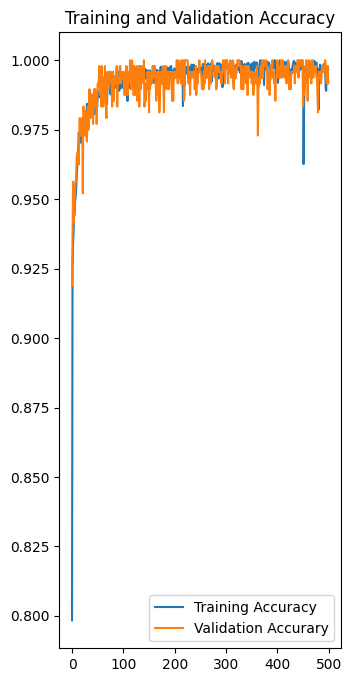

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accurary')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

image to predict
images actual label: 2. Melanoma 15.75k
1/1 [==============================] - 1s 699ms/step
predicted label: 2. Melanoma 15.75k


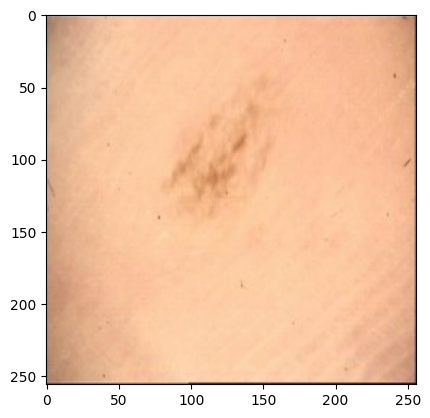

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("image to predict")
    plt.imshow(first_image)
    print("images actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


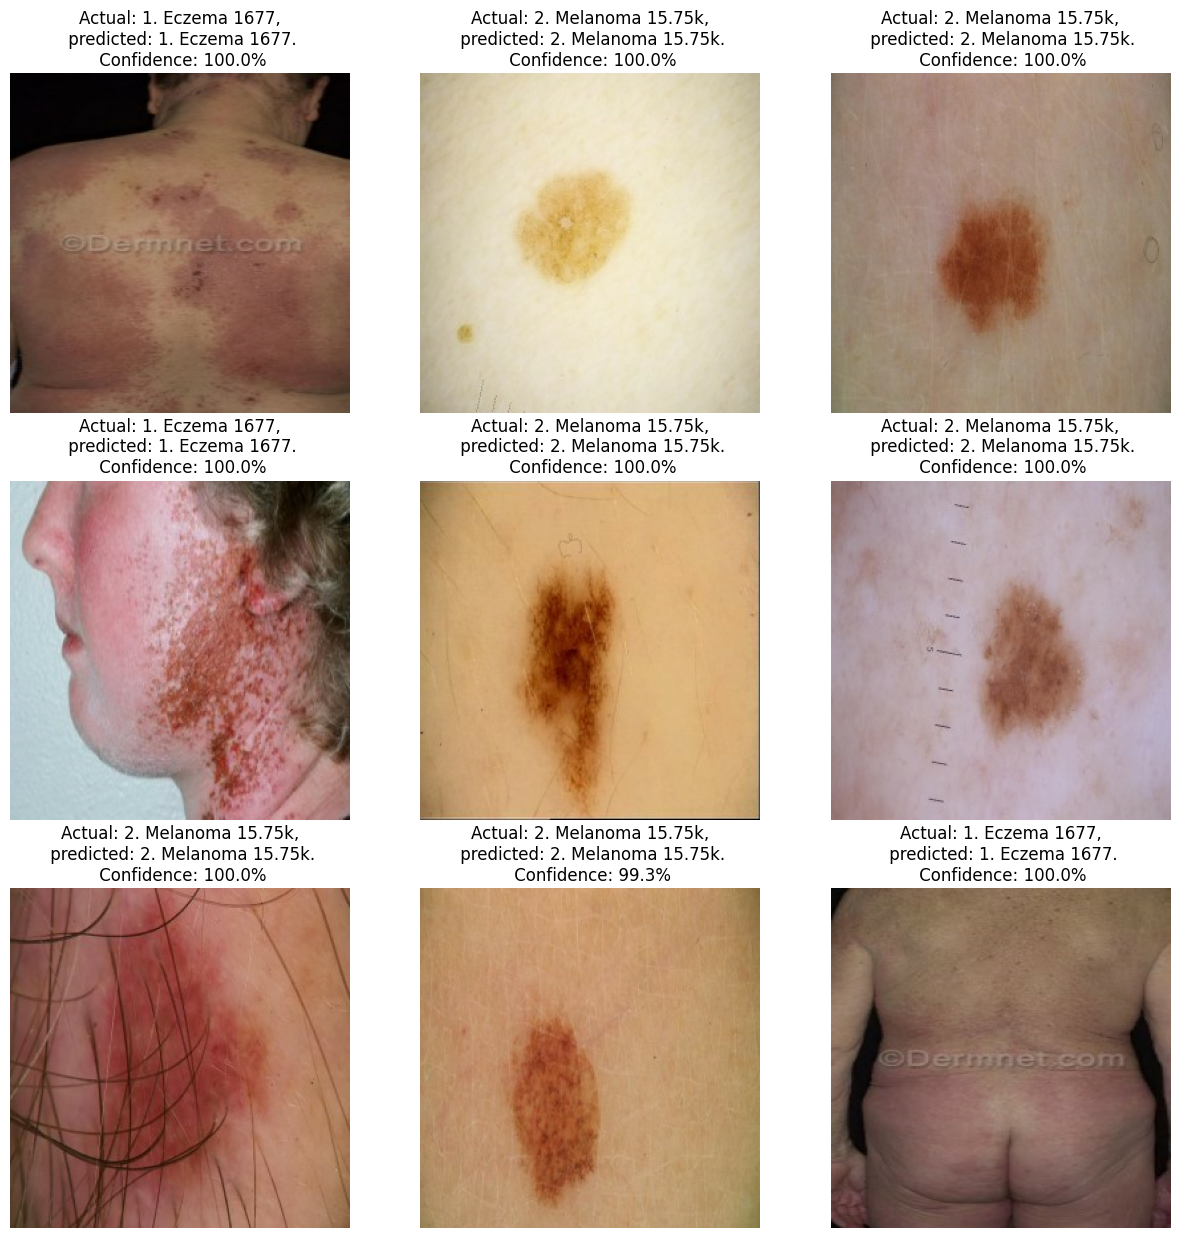

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(19):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [34]:
model_version=3
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
